In [1]:
#Import libraries
os.chdir("/home/robbe/ionbot/")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import os
from pathlib import Path
from pyteomics import mass as pymass
import OxiAnalysis as OA
import importlib
importlib.reload(OA)
import warnings; warnings.simplefilter('ignore')

Goal here: make a fingerprint of delta masses for control vs treatment and then subtract control fingerprint from treatment fingerprint

# PXD022545

## Intensity based

### Calculations

In [3]:
cols = ['Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234',
       'Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719',
       'Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239',
       'Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01',
       'Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_02',
       'Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_03']

In [6]:
PXD022545 = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD022545/mzml_files/QuantifiedPeptides.tsv", sep="\t")
PXD022545.drop(list(PXD022545.filter(regex = 'Detection Type')), axis = 1, inplace = True)
PXD022545 = PXD022545[~PXD022545["Protein Groups"].str.contains("sp|", na=False, regex=False)]

In [7]:
OA.quantile_transform(PXD022545, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_02,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_03,Unnamed: 17
0,AAAAAAAAAVSRnan,AAAAAAAAAVSR,ZFP91_HUMAN,NaN,NaN,3.733940,3.589637,NaN,NaN,NaN,NaN,NaN
1,AAAAAAAGDSDSWDADAFSVEDPVRK12|[5]Carbamyl[S],AAAAAAAGDSDSWDADAFSVEDPVRK,EIF3J_HUMAN,NaN,NaN,3.716467,NaN,3.561890,3.946052,4.113257,3.887281,NaN
2,AAAAAAALQAKnan,AAAAAAALQAK,RL4_HUMAN,NaN,NaN,6.387521,6.051924,6.750307,6.301316,6.027221,6.654968,NaN
3,AAAAADGPPAADGEDGQDPHSK4|semi_tryptic,AAAAADGPPAADGEDGQDPHSK,TXND5_HUMAN,NaN,NaN,4.124784,4.579029,3.761644,4.169677,3.022573,3.027022,NaN
4,AAAAADLANRnan,AAAAADLANR,NaN,NaN,NaN,3.871611,4.505965,4.163605,4.570736,4.359699,4.338727,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
34439,YYTVFDRDNNRnan,YYTVFDRDNNR,CATD_HUMAN,NaN,NaN,NaN,5.406446,2.881125,6.053867,6.198832,6.087029,NaN
34440,YYTVFDRnan,YYTVFDR,CATD_HUMAN,NaN,NaN,6.528381,6.705965,6.669495,6.805990,6.650565,6.725180,NaN
34441,YYVTIIDAPGHRDFIKnan,YYVTIIDAPGHRDFIK,NaN,NaN,NaN,5.282522,5.538278,5.934751,4.859113,2.695366,5.803424,NaN
34442,YYVTIIDAPGHRnan,YYVTIIDAPGHR,NaN,NaN,NaN,6.764500,6.849645,7.100431,6.655089,6.383891,7.157728,NaN


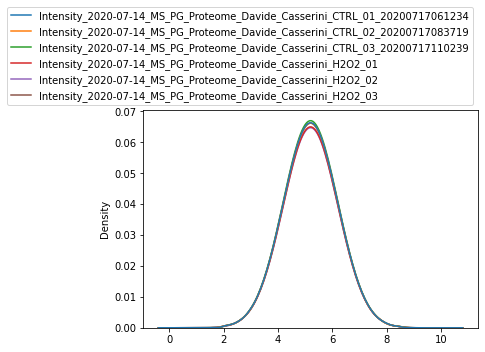

In [11]:
ax = sns.kdeplot(data=PXD022545[cols])
sns.move_legend(ax, "lower right", bbox_to_anchor=(1, 1))

In [8]:
db = pymass.Unimod()

In [9]:
def modifications(seq):
    if seq.endswith("nan"):
        return None
    else:
        pattern = re.compile(pattern=r"\[(\d+)\]")
        matches = re.findall(pattern, seq)
        if matches != None:
            for i in matches:
                return [i for i in matches]
                
def get_delta_mass(seq):
    
    if seq.endswith("nan"):
        return 0
    else:
        pattern = re.compile(pattern=r"\[(\d+)\]")
        matches = re.findall(pattern, seq)
        if matches != None:
            delta_mass = 0
            for i in matches:
                    for p in range(len(db.mods)):
                        if db.mods[p]['record_id'] == float(i):
                
                            mm = db.mods[p]['mono_mass']
                            # mm = db.mods[p]['delta_mono_mass']
                            delta_mass += mm
                            delta_mass = round(delta_mass, 2)
            return delta_mass
        else:
            return 0
                    

                

In [14]:
PXD022545["Modifications"] = PXD022545["Sequence"].apply(modifications)
PXD022545["Delta_mass"] = PXD022545["Sequence"].apply(get_delta_mass)

In [15]:
No_zero = PXD022545[PXD022545["Delta_mass"] != 0]

In [16]:
# g = No_zero.groupby("Delta_mass").median().reset_index()
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [17]:

from statistics import median


g['medianCtrl']=g.apply(lambda x:median([x[c] for c in g.columns if "CTRL" in c]),axis=1)
g["medianH2O2"]=g.apply(lambda x:median([x[c] for c in g.columns if "H2O2" in c]), axis=1)
# g['Quotient']=(g["medianH2O2"] - g["medianCtrl"]) / max([g["medianCtrl"], g["medianH2O2"]])
# g["Quotient"] = ((g["medianH2O2"] - g["medianCtrl"])/ g["medianCtrl"]).where( g["medianCtrl"] >= g["medianH2O2"], other=(g["medianH2O2"] - g["medianCtrl"])/ g["medianH2O2"])
# g["Quotient"] = ((g["medianH2O2"] - g["medianCtrl"])/ g["medianH2O2"]).where( g["medianCtrl"] < g["medianH2O2"])
g["Difference"] = (g["medianH2O2"] - g["medianCtrl"])

In [18]:
# gfiltered = g[(g["medianCtrl"] !=0) & (g["medianH2O2"] !=0) ]


### Plots

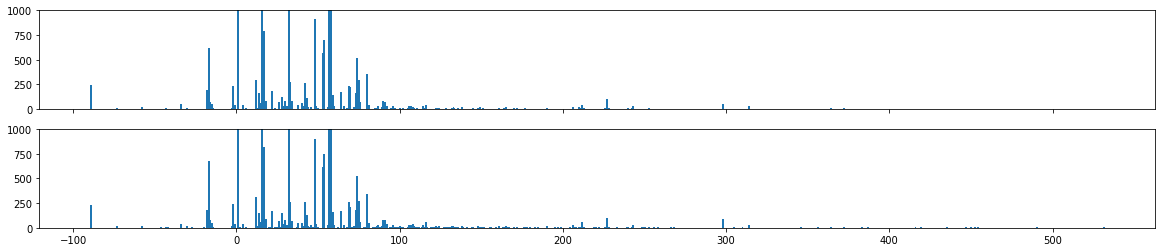

In [19]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)
# sns.barplot(ax = axes[0], data=gfiltered, x="Delta_mass", y="meanH2O2")
# sns.barplot(ax = axes[1], data=gfiltered, x="Delta_mass", y="meanCtrl")
ax1.bar(x=g.Delta_mass, height=g.medianH2O2, width=1.2)
ax2.bar(x=g.Delta_mass, height=g.medianCtrl, width=1.2)

fig.set_size_inches(20,4)
plt.ylim(0,1000)
plt.show()

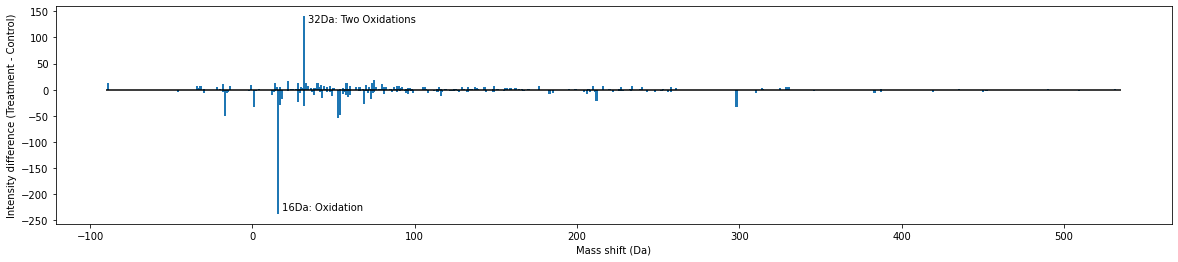

In [23]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.Difference, width=1.4)
fig.set_size_inches(20,4)
plt.hlines(y=0,xmin=-90, xmax=535, color="k")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Intensity difference (Treatment - Control)")
# plt.ylim(0,7000)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.text(x= 18, y= -230, s= "16Da: Oxidation")
plt.text(x=34, y= 130, s="32Da: Two Oxidations")
plt.show()

In [21]:
# gfiltered["Quotient"].replace(np.inf, np.nan, inplace=True)
# gfiltered["Quotient"].replace(np.nan, 0, inplace=True)
sorted = g.sort_values(by="Difference", axis=0, ascending=False)

In [22]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_02,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_03,Unnamed: 17,medianCtrl,medianH2O2,Difference
83,31.98,0.0,0.0,3085.232259,3067.098970,2968.677377,3266.652581,3120.798912,3207.745015,0.0,3067.098970,3207.745015,140.646044
184,75.01,0.0,0.0,295.799208,272.903591,249.002746,286.296075,291.808396,309.118295,0.0,272.903591,291.808396,18.904805
64,21.98,0.0,0.0,168.692511,172.439360,170.265523,186.547116,190.741007,178.890375,0.0,170.265523,186.547116,16.281593
86,33.02,0.0,0.0,265.646572,257.589887,247.414958,271.074960,274.250440,265.412145,0.0,257.589887,271.074960,13.485073
49,14.02,0.0,0.0,140.530857,157.638800,152.092646,174.775233,165.072835,154.962043,0.0,152.092646,165.072835,12.980189
148,58.01,0.0,0.0,2502.874746,2487.448881,2407.085731,2286.451987,2500.311464,2512.897789,0.0,2487.448881,2500.311464,12.862583
0,-89.03,0.0,0.0,227.671209,231.530918,211.038132,244.319953,240.433055,237.834244,0.0,227.671209,240.433055,12.761846
72,28.03,0.0,0.0,89.204741,78.354144,72.625108,90.969417,93.578711,90.324803,0.0,78.354144,90.969417,12.615273
103,40.03,0.0,0.0,73.322034,49.965440,52.148110,55.517383,72.889952,64.480031,0.0,52.148110,64.480031,12.331921
180,73.99,0.0,0.0,75.131942,94.871339,86.012877,98.222833,92.574056,99.380972,0.0,86.012877,98.222833,12.209956


31.989830: Two Oxidations!

75.012042: Fluoro + Carbamidomethylation

21.981943: Sodium adduct

33.021464: Ammonium + Oxidation

14.015650: Methylation

58.005479: Carboxymethyl!

-89.029920: Loss of methionine + acetylation of new N-term

28.03: Acetaldehyde adduct or dimethylation or ethylation 

40.031300: Propionaldehyde adduct

73.99: Oxidation + Carbamidomethylation + deamidation


In [28]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_02,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_03,Unnamed: 17,medianCtrl,medianH2O2,Difference
71,27.99,0.0,0.0,146.871513,160.334493,146.811401,133.938160,123.244184,122.181858,0.0,146.871513,123.244184,-23.627329
170,68.90,0.0,0.0,261.815144,264.906582,247.029506,249.685680,228.215584,235.007962,0.0,261.815144,235.007962,-26.807182
55,16.97,0.0,0.0,754.670483,815.689990,812.573965,826.004846,770.702480,783.494358,0.0,812.573965,783.494358,-29.079607
84,31.99,0.0,0.0,898.125379,1031.177304,1078.624125,1027.364232,998.966056,950.740900,0.0,1031.177304,998.966056,-32.211248
488,298.15,0.0,0.0,87.553528,94.812184,83.998862,55.109590,57.746962,50.036011,0.0,87.553528,55.109590,-32.443938
35,0.98,0.0,0.0,2282.290506,2335.520792,2348.866447,2300.362429,2387.820187,2301.679213,0.0,2335.520792,2301.679213,-33.841579
134,53.92,0.0,0.0,771.461757,749.711656,705.658145,749.818676,652.635915,701.867526,0.0,749.711656,701.867526,-47.844130
21,-17.03,0.0,0.0,677.910542,647.880957,671.900002,628.008650,621.316449,620.248408,0.0,671.900002,621.316449,-50.583553
132,52.91,0.0,0.0,639.870270,618.567975,589.448822,603.558706,538.572925,563.994749,0.0,618.567975,563.994749,-54.573225
54,15.99,0.0,0.0,18882.960900,18854.522078,19296.467078,18644.926608,18578.370685,19088.488683,0.0,18882.960900,18644.926608,-238.034292


15.994915: Oxidation

52.911464: Replacement of 3 protons by iron	

-17.026549: Ammonium loss

0.984016: Deamidation

298.146347: biotin hydrazide labeled acrolein addition

31.989829: Dioxidation

16.97: Oxidation + deamidation

68.906379: Oxidation + Replacement of 3 protons by iron

27.99: Formylation or oxidation + Thiazolidine





# PXD012477

## Intensity based

### Pre-calculations

In [36]:
PXD012477 = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD012477/flashlfq_results/QuantifiedPeptides.tsv", sep="\t")
PXD012477.drop(list(PXD012477.filter(regex = 'Detection Type')), axis = 1, inplace = True)
PXD012477.head()

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_1DLC0080815QE_RRAG_001_rep1,Intensity_1DLC0080815QE_RRAG_001_rep2,Intensity_1DLC120314QE_RRAG_001_rep1,Intensity_1DLC120314QE_RRAG_001_rep2,Intensity_1DLC012615QE_RRAG_001B_rep1,...,Intensity_1DLC012615QE_RRAG_008B_rep4,Intensity_1DLC120914QE_RRAG_009_rep1,Intensity_1DLC120914QE_RRAG_009_rep2,Intensity_1DLC120914QE_RRAG_009_rep3,Intensity_1DLC120914QE_RRAG_009_rep4,Intensity_1DLC012615QE_RRAG_009B_rep1,Intensity_1DLC012615QE_RRAG_009B_rep2,Intensity_1DLC012615QE_RRAG_009B_rep3,Intensity_1DLC012615QE_RRAG_009B_rep4,Unnamed: 983
0,AAAAAAAAAAAAAAAASAGGKx|[1927]Delta:H(4)C(5)O(1...,AAAAAAAAAAAAAAAASAGGK,NaN,NaN,NaN,0.0,0.0,138225.983265,132484.074364,164815.085379,...,84877.380967,11178.165559,50411.293713,0.000000,0.000000,11447.805538,0.0,8570.250729,0.000000,NaN
1,AAAAAAAAAKNGSSGKnan,AAAAAAAAAKNGSSGK,NaN,NaN,NaN,0.0,0.0,59682.551616,33086.921842,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN
2,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.0,0.0,185776.556271,21026.774331,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN
3,AAAAAAAAGAFAGRR7|[1918]Carbonyl[A],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN
4,AAAAAAAAQMHAKx|[205]Delta:H(6)C(6)O(1)[K],AAAAAAAAQMHAK,NaN,NaN,NaN,0.0,0.0,27244.860745,22892.768392,317624.729897,...,202659.820247,26194.228624,0.000000,121790.360066,26474.929387,61698.145139,0.0,0.000000,17235.695643,NaN


In [37]:
cols =[]
for i in PXD012477.columns[5:-1]:
    cols.append(i)

In [38]:
OA.quantile_transform(PXD012477, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_1DLC0080815QE_RRAG_001_rep1,Intensity_1DLC0080815QE_RRAG_001_rep2,Intensity_1DLC120314QE_RRAG_001_rep1,Intensity_1DLC120314QE_RRAG_001_rep2,Intensity_1DLC012615QE_RRAG_001B_rep1,...,Intensity_1DLC012615QE_RRAG_008B_rep4,Intensity_1DLC120914QE_RRAG_009_rep1,Intensity_1DLC120914QE_RRAG_009_rep2,Intensity_1DLC120914QE_RRAG_009_rep3,Intensity_1DLC120914QE_RRAG_009_rep4,Intensity_1DLC012615QE_RRAG_009B_rep1,Intensity_1DLC012615QE_RRAG_009B_rep2,Intensity_1DLC012615QE_RRAG_009B_rep3,Intensity_1DLC012615QE_RRAG_009B_rep4,Unnamed: 983
0,AAAAAAAAAAAAAAAASAGGKx|[1927]Delta:H(4)C(5)O(1...,AAAAAAAAAAAAAAAASAGGK,NaN,NaN,NaN,NaN,NaN,5.858407,5.897686,5.883941,...,5.510266,3.977395,5.023162,NaN,NaN,4.203044,NaN,4.028068,NaN,NaN
1,AAAAAAAAAKNGSSGKnan,AAAAAAAAAKNGSSGK,NaN,NaN,NaN,NaN,NaN,5.182500,4.744882,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,6.071816,4.376360,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAAAAAGAFAGRR7|[1918]Carbonyl[A],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAAAAAAQMHAKx|[205]Delta:H(6)C(6)O(1)[K],AAAAAAAAQMHAK,NaN,NaN,NaN,NaN,NaN,4.572496,4.443170,6.335264,...,6.063617,4.535847,NaN,5.411331,4.516309,5.119418,NaN,NaN,4.506613,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102383,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[100...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102384,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[131...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102385,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[6]C...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102386,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[999...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
PXD012477["Modifications"] = PXD012477["Sequence"].apply(modifications)
PXD012477["Delta_mass"] = PXD012477["Sequence"].apply(get_delta_mass)

In [40]:
No_zero = PXD012477[PXD012477["Delta_mass"] != 0]

In [41]:
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [42]:
g

,Delta_mass,Gene Names,Organism,Intensity_1DLC0080815QE_RRAG_001_rep1,Intensity_1DLC0080815QE_RRAG_001_rep2,Intensity_1DLC120314QE_RRAG_001_rep1,Intensity_1DLC120314QE_RRAG_001_rep2,Intensity_1DLC012615QE_RRAG_001B_rep1,Intensity_1DLC012615QE_RRAG_001B_rep2,Intensity_1DLC012615QE_RRAG_001B_rep3,...,Intensity_1DLC012615QE_RRAG_008B_rep4,Intensity_1DLC120914QE_RRAG_009_rep1,Intensity_1DLC120914QE_RRAG_009_rep2,Intensity_1DLC120914QE_RRAG_009_rep3,Intensity_1DLC120914QE_RRAG_009_rep4,Intensity_1DLC012615QE_RRAG_009B_rep1,Intensity_1DLC012615QE_RRAG_009B_rep2,Intensity_1DLC012615QE_RRAG_009B_rep3,Intensity_1DLC012615QE_RRAG_009B_rep4,Unnamed: 983
0,-94.041865,0.0,0.0,5.288978,9.549858,16.531377,10.774835,27.380648,26.654922,5.417397,...,16.575982,24.990239,20.157675,18.154860,17.782556,18.752673,22.195756,12.871445,20.759450,0.0
1,-89.029920,0.0,0.0,81.434986,99.068373,124.537088,143.645287,124.674463,140.736329,54.850434,...,122.778599,110.620429,129.527154,118.717986,120.027516,89.878552,102.634074,106.534876,95.579879,0.0
2,-78.046950,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,5.225564,0.000000,0.000000,0.000000,0.000000,0.000000,4.563862,0.0
3,-73.035005,0.0,0.0,5.917819,0.000000,0.000000,4.612289,0.000000,0.000000,5.238051,...,5.552057,6.019940,5.473394,5.650605,5.584276,9.076900,5.281757,4.822885,0.000000,0.0
4,-58.005479,0.0,0.0,26.798571,29.789605,57.667273,52.750318,59.150582,51.672302,20.033680,...,75.274449,57.730431,67.786022,59.155301,46.396663,70.686263,51.706552,63.485009,82.522488,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,557.244541,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1613,563.190597,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1614,587.262499,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1615,588.293443,0.0,0.0,0.000000,0.000000,0.000000,4.622689,6.231109,5.797805,0.000000,...,3.489459,0.000000,0.000000,0.000000,4.447450,0.000000,0.000000,5.036801,0.000000,0.0


In [43]:
dict = {}
patientIDlist = []
patientIDBlist = []
for i in range(1,66):
    patientID = "_"+str(i).zfill(3)+"_"
    patientIDB = "_"+str(i).zfill(3)+"B_"
    patientIDlist.append(patientID)
    patientIDBlist.append(patientIDB)
for patient in patientIDlist:
    selected = g[[col for col in g if patient in col]]
    selected["Delta_mass"] = g["Delta_mass"]
    dict[patient] = selected
for patientB in patientIDBlist:
    selectedB = g[[col for col in g if patientB in col]]
    selected["Delta_mass"] = g["Delta_mass"]
    dict[patientB] = selectedB

In [44]:
for i in dict:
    df = dict[i]
    df["median"] = df.median(axis=1)

In [45]:
data = pd.DataFrame()
data["Delta_mass"] = g["Delta_mass"]
for patient in dict:
    data[patient] = dict[patient]["median"]

In [46]:
data.dropna(axis=1, inplace=True)
data

,Delta_mass,_001_,_002_,_003_,_004_,_005_,_006_,_007_,_008_,_009_,...,_053B_,_054B_,_055B_,_056B_,_058B_,_059B_,_060B_,_061B_,_062B_,_064B_
0,-94.041865,9.549858,6.199684,4.916327,13.478940,13.768652,15.287587,17.333435,12.510942,18.154860,...,7.949539,0.000000,7.084016,4.884702,6.550274,0.000000,13.437220,5.080616,2.247756,15.052359
1,-89.029920,99.068373,63.693538,100.622481,99.048083,110.009395,122.229189,95.431060,109.243962,118.717986,...,104.269997,61.413587,81.010613,133.784592,117.752800,50.994648,110.170965,128.953137,102.109253,134.600027
2,-78.046950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-73.035005,0.000000,0.000000,0.000000,5.165159,0.000000,0.000000,0.000000,5.128251,5.584276,...,4.544528,5.263862,5.214332,5.294136,0.000000,4.996144,4.904302,4.696375,4.518662,0.000000
4,-58.005479,29.789605,30.633576,50.555017,30.908377,58.879198,60.379289,64.528958,66.189972,57.730431,...,59.416652,49.086682,57.535841,60.963548,50.558479,47.190421,59.285765,57.929708,51.629417,57.670511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,557.244541,0.000000,0.000000,0.000000,0.000000,3.296599,3.393711,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1613,563.190597,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1614,587.262499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1615,588.293443,0.000000,0.000000,0.000000,0.000000,4.875569,4.286715,3.830873,4.076379,0.000000,...,0.000000,2.657254,2.687719,5.555856,5.836680,2.903652,2.647237,4.599346,0.000000,4.493865


In [47]:
Healthydf = pd.DataFrame()
NonHealthydf = pd.DataFrame()
Healthydf["Delta_mass"] = data["Delta_mass"]
NonHealthydf["Delta_mass"] = data["Delta_mass"]
Healthy = [1,3,4,5,6,11,13,14,19,21,23,24,25,28,29,32,33,34,36,37,40,41,42,47,52,54,56,57,60,61,65]
NonHealthy = [2,7,9,10,12,15,17,18,20,22,26,27,30,31,35,38,39,43,44,45,46,48,49,50,51,53,55,58,59,62,63,64,8,16]
patienlist = []
patienBlist = []
for i in Healthy:
    patien = "_"+str(i).zfill(3)+"_"
    patienlist.append(patien)
    patienB = "_"+str(i).zfill(3)+"B_"
    patienBlist.append(patienB)

for i in patienlist:
    if i in data.columns:
        Healthydf[i] = data[i]
for i in patienBlist:
    if i in data.columns:
        Healthydf[i] = data[i]


patielist = []
patieBlist = []
data["Delta_mass"] = g["Delta_mass"]
for i in NonHealthy:
    patie = "_"+str(i).zfill(3)+"_"
    patielist.append(patie)
    patieB = "_"+str(i).zfill(3)+"B_"
    patieBlist.append(patieB)

for i in patielist:
    if i in data.columns:
        NonHealthydf[i] = data[i]
for i in patieBlist:
    if i in data.columns:
        NonHealthydf[i] = data[i]

In [48]:
Healthydf.set_index("Delta_mass",inplace=True)
Healthy = Healthydf.median(axis=1).to_frame().reset_index()

NonHealthydf.set_index("Delta_mass", inplace=True)
NonHealthy = NonHealthydf.median(axis=1).to_frame().reset_index()


In [50]:
data = pd.merge(Healthy, NonHealthy, how="outer", on=["Delta_mass", "Delta_mass"], suffixes=["H","NH"])

In [51]:
data

,Delta_mass,0H,0NH
0,-94.041865,11.892461,12.410639
1,-89.029920,110.125174,105.328042
2,-78.046950,0.000000,0.000000
3,-73.035005,3.380142,4.688720
4,-58.005479,58.404453,54.428428
...,...,...,...
1612,557.244541,0.000000,0.000000
1613,563.190597,0.000000,0.000000
1614,587.262499,0.000000,0.000000
1615,588.293443,2.816070,2.370502


In [52]:
# data["Quotient"] = ((data["0NH"] - data["0H"])/ data["0H"]).where( data["0H"] >= data["0NH"], other=(data["0NH"] - data["0H"])/ data["0NH"])
data["Difference"] = data["0NH"] - data["0H"]
# data.fillna(0, inplace=True)
# g["Quotient"] = ((g["meanNH"] - g["meanH"])/ g["meanNH"]).where( g["meanH"] < g["meanNH"])


### Plots

In [53]:
data

,Delta_mass,0H,0NH,Difference
0,-94.041865,11.892461,12.410639,0.518177
1,-89.029920,110.125174,105.328042,-4.797131
2,-78.046950,0.000000,0.000000,0.000000
3,-73.035005,3.380142,4.688720,1.308578
4,-58.005479,58.404453,54.428428,-3.976025
...,...,...,...,...
1612,557.244541,0.000000,0.000000,0.000000
1613,563.190597,0.000000,0.000000,0.000000
1614,587.262499,0.000000,0.000000,0.000000
1615,588.293443,2.816070,2.370502,-0.445568


In [398]:
# datafiltered = data[(data["0H"] !=0) & (data["0NH"] !=0) ]


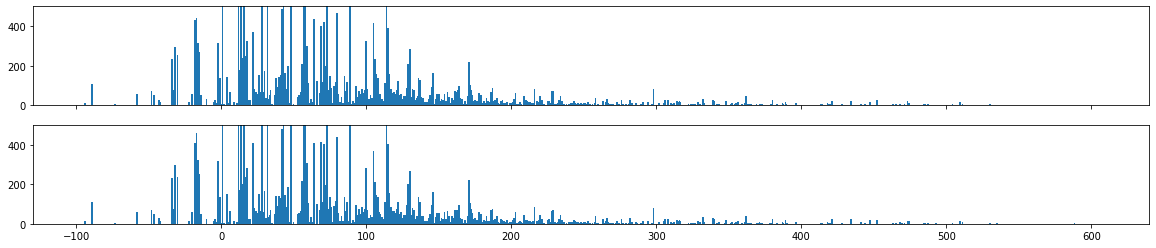

In [54]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)
# sns.barplot(ax = axes[0], data=gfiltered, x="Delta_mass", y="meanH2O2")
# sns.barplot(ax = axes[1], data=gfiltered, x="Delta_mass", y="meanCtrl")
ax1.bar(x=data.Delta_mass, height=data["0NH"], width=1.2)
ax2.bar(x=data.Delta_mass, height=data["0H"], width=1.2)

fig.set_size_inches(20,4)
plt.ylim(0,500)
plt.show()

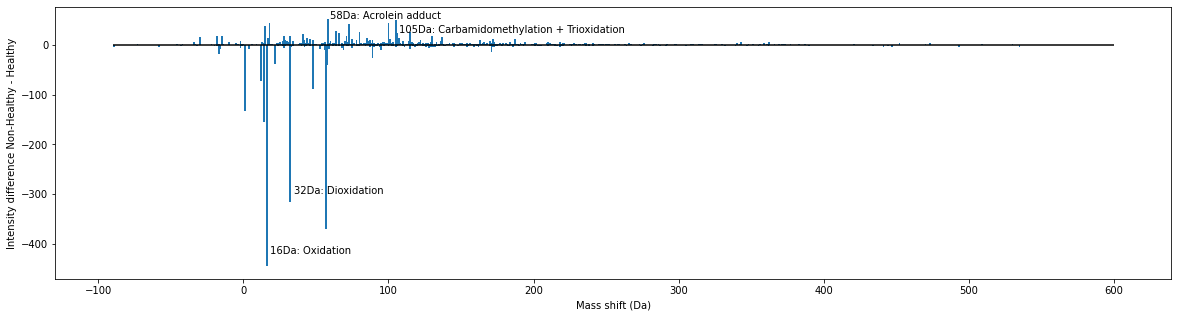

In [59]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=data.Delta_mass, height=data.Difference, width=1.2)
fig.set_size_inches(20,5)
plt.hlines(y=0,xmin=-90, xmax=600, color="k")
plt.ylabel("Intensity difference Non-Healthy - Healthy")
plt.xlabel("Mass shift (Da)")
plt.text(x=60,y=52,s="58Da: Acrolein adduct")
plt.text(x=18, y = -420, s="16Da: Oxidation")
plt.text(x = 107, y=25, s= "105Da: Carbamidomethylation + Trioxidation")
plt.text(x=35, y = -300, s="32Da: Dioxidation")

# plt.ylim(0,7000)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

In [157]:
sorted = data.sort_values(by="Difference", axis=0, ascending=False)

In [158]:
sorted.head(10)

,Delta_mass,0H,0NH,Quotient,Difference
216,58.041865,371.117558,422.077088,0.120735,50.959530
434,105.006208,368.964887,417.958548,0.117221,48.993661
405,100.027278,280.855827,325.472066,0.137082,44.616239
84,17.990578,282.728577,325.625579,0.131737,42.897002
278,73.016379,1670.758709,1711.110929,0.023582,40.352220
74,14.999666,199.812306,238.222751,0.161238,38.410445
76,15.010899,188.176656,225.389641,0.165105,37.212985
404,100.016044,161.370503,191.643486,0.157965,30.272983
241,63.979659,406.848759,434.812374,0.064312,27.963615
484,115.063329,187.708419,213.681957,0.121552,25.973538


58.041865: Reduced acrolein addition +58	

105.006208: Carbamidomethylation + Trioxidation

100.027278: Carbamidomethylation + Carbamyl

17.990578: fluorination

73.016379: Carbamidomethylation + Oxidation

14.999666: Deamidation followed by a methylation

15.010899: Aminotyrosine (staatt in lijst van Hawkins?)

100.016044: Methylmalonylation

63.979659: Tryptophan oxidation to dihydroxy-N-formaylkynurenine	

115.063329: Reduced acrolein addition +58	+ Carbamidomethylation

In [165]:
sorted.tail(10)

,Delta_mass,0H,0NH,Quotient,Difference
92,21.981943,409.296216,371.269612,-0.092907,-38.026604
213,58.005480,1239.339952,1199.561981,-0.032096,-39.777971
124,31.989830,675.327103,610.716097,-0.095674,-64.611006
62,12.000000,1882.863029,1809.174178,-0.039137,-73.688851
179,47.984744,2015.211345,1926.954906,-0.043795,-88.256440
51,0.984016,3778.496273,3647.395471,-0.034697,-131.100802
69,13.979265,1979.976857,1825.202890,-0.078170,-154.773967
123,31.989829,3464.145839,3147.443875,-0.091423,-316.701964
211,57.021464,11910.308629,11541.679925,-0.030950,-368.628703
80,15.994915,7581.167972,7138.311509,-0.058415,-442.856463


15.994915: Oxidation

57.021464: Carbamidomethylation

31.989829: Dioxidation

13.97926: Carbonylation 

0.984016: Deamidation

47.984744: Trioxidation

12: formaldehyde adduct	

31.989830: Two oxidations

58.005480: Carboxymethyl

21.981943: Sodium adduct		


# PXD016278

## Intensity based

### Calculations

In [60]:
PXD016278 = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD016278/flashlfq/QuantifiedPeptides.tsv", sep="\t")
PXD016278.drop(list(PXD016278.filter(regex = 'Detection Type')), axis = 1, inplace = True)
PXD016278.head()

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101
0,AAAAAAAAAAAAAAAGAGAGAKnan,AAAAAAAAAAAAAAAGAGAGAK,S12A2_HUMAN,NaN,NaN,0.000000e+00,0.000000,0.000,0.0,0.0,...,2.016063e+05,6.783181e+05,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,NaN
1,AAAAAAAAAKnan,AAAAAAAAAK,PHX2B_HUMAN,NaN,NaN,0.000000e+00,0.000000,0.000,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,NaN
2,AAAAAAAAAVSRR12|[981]glucosone[R],AAAAAAAAAVSRR,NaN,NaN,NaN,3.159841e+06,263986.097656,0.000,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,NaN
3,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.000000e+00,0.000000,0.000,0.0,0.0,...,1.550330e+06,2.073836e+06,0.0,0.0,0.0,0.0,3.529714e+06,2.289962e+07,0.0,NaN
4,AAAAAAAAGAFAGRR15|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.000000e+00,0.000000,6137970.625,8516465.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,NaN


In [61]:
cols =[]
for i in PXD016278.columns[5:-1]:
    cols.append(i)

In [62]:
OA.quantile_transform(PXD016278, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101
0,AAAAAAAAAAAAAAAGAGAGAKnan,AAAAAAAAAAAAAAAGAGAGAK,S12A2_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.374836,4.591134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAAAAAAAAKnan,AAAAAAAAAK,PHX2B_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAAAAAAVSRR12|[981]glucosone[R],AAAAAAAAAVSRR,NaN,NaN,NaN,5.644241,4.556679,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.714461,5.304105,NaN,NaN,NaN,NaN,5.122593,6.092077,NaN,NaN
4,AAAAAAAAGAFAGRR15|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,5.801429,5.927171,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108603,YYYAVYDMVVR8|[35]oxidation[M],YYYAVYDMVVR,LAMB1_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108604,YYYAVYDMVVRnan,YYYAVYDMVVR,LAMB1_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.489088,4.648204,NaN,NaN,NaN,NaN,NaN,NaN,4.69236,NaN
108605,YYYDGKDYIEFNK6|[4]Carbamidomethyl[K],YYYDGKDYIEFNK,ZA2G_HUMAN,NaN,NaN,5.075188,4.694472,NaN,NaN,5.021263,...,4.376519,4.546711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108606,YYYDGKDYIEFNKnan,YYYDGKDYIEFNK,ZA2G_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
PXD016278["Modifications"] = PXD016278["Sequence"].apply(modifications)
PXD016278["Delta_mass"] = PXD016278["Sequence"].apply(get_delta_mass)

In [64]:
No_zero = PXD016278[PXD016278["Delta_mass"] != 0]

In [65]:
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [66]:
g

,Delta_mass,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction06_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction07_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101
0,-94.041865,0.0,0.0,0.000000,0.000000,0.000000,5.273945,3.907864,4.245048,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.284232,0.000000,0.000000,0.000000,0.000000,0.0
1,-89.029920,0.0,0.0,5.093267,10.888405,11.128523,9.054536,28.658164,32.892761,11.471245,...,13.353761,4.996367,4.646425,11.265526,19.449107,23.286075,9.942100,0.000000,9.479501,0.0
2,-73.035005,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.733968,4.056953,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,-58.005479,0.0,0.0,5.695234,4.437082,20.283829,10.376134,0.000000,0.000000,0.000000,...,0.000000,13.854979,19.549741,10.625485,4.601573,4.737187,9.710958,5.677064,15.185990,0.0
4,-48.003371,0.0,0.0,25.628343,20.180233,42.765801,24.005694,30.380902,51.960253,52.761162,...,46.604250,52.254966,68.279221,40.515084,30.450835,32.085989,48.361448,60.278858,58.541966,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,561.238607,0.0,0.0,0.000000,0.000000,0.000000,0.000000,4.210031,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1494,563.190597,0.0,0.0,0.000000,0.000000,5.049604,4.015923,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1495,568.253315,0.0,0.0,0.000000,0.000000,4.391701,3.637485,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1496,572.205319,0.0,0.0,0.000000,0.000000,15.190195,18.636926,12.170027,12.532800,16.035672,...,5.419732,0.000000,10.116559,19.395798,21.544468,10.515483,11.067974,4.125063,5.234600,0.0


In [67]:
from statistics import median
g['medianCtrl']=g.apply(lambda x:median([x[c] for c in g.columns if "ctrl2" in c]),axis=1)
g["medianAD"]=g.apply(lambda x:median([x[c] for c in g.columns if "AD2" in c]), axis=1)

In [68]:
g

,Delta_mass,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction06_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction07_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101,medianCtrl,medianAD
0,-94.041865,0.0,0.0,0.000000,0.000000,0.000000,5.273945,3.907864,4.245048,0.000000,...,0.000000,0.000000,6.284232,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,-89.029920,0.0,0.0,5.093267,10.888405,11.128523,9.054536,28.658164,32.892761,11.471245,...,4.646425,11.265526,19.449107,23.286075,9.942100,0.000000,9.479501,0.0,9.954498,10.281688
2,-73.035005,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.733968,4.056953,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,-58.005479,0.0,0.0,5.695234,4.437082,20.283829,10.376134,0.000000,0.000000,0.000000,...,19.549741,10.625485,4.601573,4.737187,9.710958,5.677064,15.185990,0.0,5.998734,5.274432
4,-48.003371,0.0,0.0,25.628343,20.180233,42.765801,24.005694,30.380902,51.960253,52.761162,...,68.279221,40.515084,30.450835,32.085989,48.361448,60.278858,58.541966,0.0,44.167511,41.815026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,561.238607,0.0,0.0,0.000000,0.000000,0.000000,0.000000,4.210031,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1494,563.190597,0.0,0.0,0.000000,0.000000,5.049604,4.015923,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1495,568.253315,0.0,0.0,0.000000,0.000000,4.391701,3.637485,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1496,572.205319,0.0,0.0,0.000000,0.000000,15.190195,18.636926,12.170027,12.532800,16.035672,...,10.116559,19.395798,21.544468,10.515483,11.067974,4.125063,5.234600,0.0,5.327166,10.723634


In [86]:
# g["Quotient"] = ((g["medianAD"] - g["medianCtrl"])/ g["medianCtrl"]).where( g["medianCtrl"] >= g["medianAD"], other=(g["medianAD"] - g["medianCtrl"])/ g["medianAD"])

In [69]:
g["Difference"] = g["medianAD"] - g["medianCtrl"]

In [91]:
# g["Quotient"].replace(np.nan, 0, inplace=True)

In [95]:
# gfiltered = g[(g["medianCtrl"] !=0) & (g["medianH2O2"] !=0) ]


### Plots

In [70]:
g

,Delta_mass,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction06_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction07_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101,medianCtrl,medianAD,Difference
0,-94.041865,0.0,0.0,0.000000,0.000000,0.000000,5.273945,3.907864,4.245048,0.000000,...,0.000000,6.284232,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,-89.029920,0.0,0.0,5.093267,10.888405,11.128523,9.054536,28.658164,32.892761,11.471245,...,11.265526,19.449107,23.286075,9.942100,0.000000,9.479501,0.0,9.954498,10.281688,0.327189
2,-73.035005,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.733968,4.056953,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,-58.005479,0.0,0.0,5.695234,4.437082,20.283829,10.376134,0.000000,0.000000,0.000000,...,10.625485,4.601573,4.737187,9.710958,5.677064,15.185990,0.0,5.998734,5.274432,-0.724302
4,-48.003371,0.0,0.0,25.628343,20.180233,42.765801,24.005694,30.380902,51.960253,52.761162,...,40.515084,30.450835,32.085989,48.361448,60.278858,58.541966,0.0,44.167511,41.815026,-2.352486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,561.238607,0.0,0.0,0.000000,0.000000,0.000000,0.000000,4.210031,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1494,563.190597,0.0,0.0,0.000000,0.000000,5.049604,4.015923,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1495,568.253315,0.0,0.0,0.000000,0.000000,4.391701,3.637485,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1496,572.205319,0.0,0.0,0.000000,0.000000,15.190195,18.636926,12.170027,12.532800,16.035672,...,19.395798,21.544468,10.515483,11.067974,4.125063,5.234600,0.0,5.327166,10.723634,5.396468


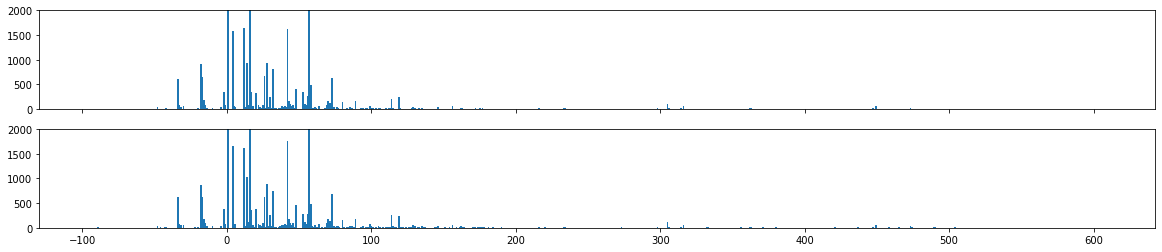

In [71]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)
# sns.barplot(ax = axes[0], data=gfiltered, x="Delta_mass", y="meanH2O2")
# sns.barplot(ax = axes[1], data=gfiltered, x="Delta_mass", y="meanCtrl")
ax1.bar(x=g.Delta_mass, height=g.medianAD, width=1.2)
ax2.bar(x=g.Delta_mass, height=g.medianCtrl, width=1.2)

fig.set_size_inches(20,4)
plt.ylim(0,2000)
plt.show()

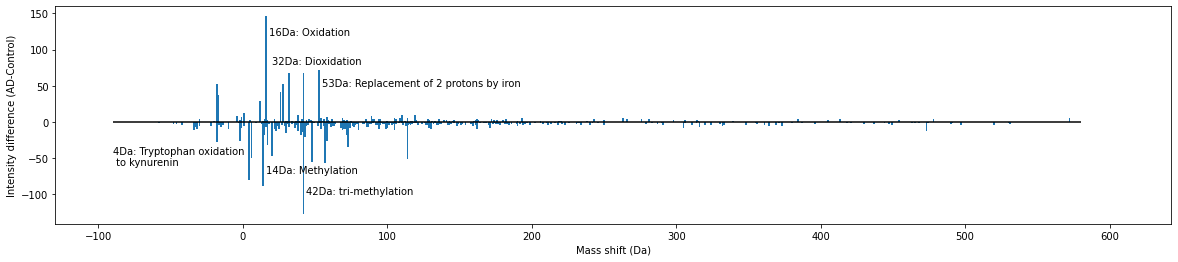

In [87]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.Difference, width=1.2)
fig.set_size_inches(20,4)
plt.hlines(y=0,xmin=-90, xmax=580, color="k")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Intensity difference (AD-Control)")
plt.text(x=18, y= 120, s= "16Da: Oxidation")
plt.text(x=20, y= 80, s="32Da: Dioxidation")
plt.text(x=55, y=50, s= "53Da: Replacement of 2 protons by iron")
plt.text(x=44, y = -100, s="42Da: Tri-methylation")
plt.text(x=16, y = -70, s="14Da: Methylation")
plt.text(x=-90, y=-60, s="4Da: Tryptophan oxidation \n to kynurenin")
# plt.ylim(0,7000)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

In [215]:
sorted = g.sort_values(by="Difference", axis=0, ascending=False)

In [216]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction06_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction07_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101,medianCtrl,medianAD,Difference
80,15.994915,0.0,0.0,3219.615599,3634.081097,5450.713125,5767.650192,6093.958197,6828.062404,5515.164456,...,5242.857507,5006.842456,5127.766353,4986.362612,5154.844079,5321.446399,0.0,5207.740667,5352.236628,144.495960
195,52.911464,0.0,0.0,129.178977,181.534363,385.588391,326.180889,271.817626,237.683933,178.309636,...,209.896402,328.025802,336.724257,198.107811,168.513219,262.901777,0.0,281.977485,354.111519,72.134035
158,42.010565,0.0,0.0,277.775968,383.366878,538.778784,382.802519,378.361192,423.543431,328.503361,...,487.222867,515.245005,512.470111,553.466917,563.413893,589.229718,0.0,511.414924,579.403864,67.988940
125,31.989829,0.0,0.0,546.577021,652.374395,817.040208,873.500019,933.914059,941.600796,1004.112373,...,713.108582,647.661405,731.188348,690.480264,712.289920,774.803730,0.0,747.023702,814.709452,67.685750
23,-18.010565,0.0,0.0,569.330456,660.396707,934.386543,859.579000,922.656232,845.613520,864.272647,...,842.551330,839.691715,982.704576,941.234116,849.515342,876.018154,0.0,865.428403,918.735700,53.307297
106,27.994915,0.0,0.0,1245.629350,692.514181,829.694942,902.677228,848.193487,879.440372,937.365832,...,950.915907,821.289744,786.211371,651.267886,997.519030,1160.925072,0.0,888.715709,941.295285,52.579576
100,26.015650,0.0,0.0,234.587283,316.782503,479.732348,474.194932,413.144362,473.877421,445.631770,...,728.193898,810.391187,623.258370,586.075998,638.327102,671.390402,0.0,631.002971,671.905902,40.902931
25,-17.026549,0.0,0.0,348.067574,345.804935,631.438051,692.118855,676.509879,706.178461,598.686311,...,666.361096,638.424174,769.312063,760.461992,641.642817,659.321751,0.0,622.782512,659.944158,37.161646
60,12.000000,0.0,0.0,718.037662,1041.518623,1547.926971,1427.192697,1263.374189,1374.122546,1232.890659,...,1650.762341,1607.722893,1572.849638,1585.802165,1620.117022,1700.772733,0.0,1613.919958,1643.212036,29.292079
108,28.031300,0.0,0.0,232.681303,303.279309,391.931913,315.358017,343.753883,367.332457,383.021879,...,587.181643,483.063059,454.188064,456.749793,438.094479,561.036067,0.0,459.491127,483.134535,23.643408


15.994915: Oxidation (yes)

52.911464: Replacement of 3 protons by iron	 (iron accumulation is definitely associated but AD but maybe a stretch)

42.010565: Acetylation (can't really find anything)

31.989829: Dioxidation (yes)

-18.010565: Dehydration (a range of diff. things depending on what AA)

27.994915: Formylation (can't find anything, Unimod says this is artefact)

26.015650: Acetaldehyde adduct (Aldehyde metabolism is impaired in AD but maybe a stretch)

-17.026549	: Loss of ammonia	(can't really find anything)

12: formaldehyde adduct	(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6878761/)

28.031300: Acetaldehyde +28	adduct (Again!)

In [217]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction06_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction07_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101,medianCtrl,medianAD,Difference
83,17.026549,0.0,0.0,60.578825,99.252528,151.357544,114.902529,61.876133,72.584305,60.203373,...,76.870641,86.946714,80.525458,82.217574,60.111456,84.573598,0.0,109.031170,76.544654,-32.486516
283,73.016379,0.0,0.0,316.852026,437.629126,681.043609,738.627354,717.552866,805.117398,794.034163,...,522.883771,575.406673,612.279353,597.469996,624.214611,603.548607,0.0,673.970870,639.995374,-33.975496
88,19.989830,0.0,0.0,172.200667,194.005274,288.979205,320.939888,315.918192,321.792990,262.788718,...,386.022915,348.724001,318.070237,286.638966,311.705928,400.956377,0.0,374.935170,327.544750,-47.390420
56,6.008178,0.0,0.0,10.337269,26.825771,30.478787,34.567710,24.208069,27.717310,55.970649,...,83.657341,78.340888,87.457546,66.764383,56.883258,95.346763,0.0,85.557444,35.768730,-49.788714
477,114.042928,0.0,0.0,103.141888,99.798098,196.122993,273.921629,204.130942,219.375277,207.647359,...,250.714571,259.709749,285.516805,234.856269,267.904662,198.568773,0.0,250.692956,199.632812,-51.060144
186,47.984744,0.0,0.0,264.751848,338.818699,425.122551,466.878180,501.783614,505.538404,432.151986,...,439.955310,367.220918,446.339215,467.238249,454.574749,505.177980,0.0,460.906499,405.338220,-55.568279
217,57.021464,0.0,0.0,2504.914934,2870.130358,4631.872110,4653.464909,4321.040390,4554.840127,4103.556482,...,4406.239757,4730.692216,4447.148065,4144.275324,4157.899241,4454.384311,0.0,4713.829498,4655.492452,-58.337046
53,3.994915,0.0,0.0,964.105090,1273.825819,1502.620134,1621.817461,1734.618927,1879.497433,1667.408615,...,1962.195615,1634.095348,1453.177810,1342.239581,1359.779056,1881.951489,0.0,1663.692713,1586.239159,-77.453554
70,14.015650,0.0,0.0,404.415271,635.120756,929.938453,958.997931,783.837832,775.633085,767.975502,...,1038.753330,1048.392349,1083.965277,883.681033,857.791033,1109.530723,0.0,1032.936403,944.468192,-88.468211
160,42.046950,0.0,0.0,664.552563,816.156139,1161.267808,1044.449516,1049.477448,1197.164479,1167.292156,...,2134.430908,2246.641417,1975.470451,1211.715877,1314.449001,2006.759129,0.0,1751.321628,1626.462922,-124.858706


42.046950: tri-methylation

14.015650: methylation

3.994915: tryptophan oxidation to kynurenin (Conflicting reports, some say kynurenin pathway is reduced in AD patients, but this is talking about metabolites, can't really find data on protein modificaitons)

57.021464: Carbamidomethyl (Artefact, probably)

47.984744: Trioxidaiton (Weird)

114.042928: Ubiquitination 

6.008178: Replacement of proton by lithium	()

19.989830: tryptophan oxidation to hydroxykynurenin

73.016379: Oxidation + Carbamidomethyl

17.026549: replacement of proton with ammonium ion	



# PXD014381

### Calculations

In [9]:
cols = ['Intensity_QX01983',
       'Intensity_QX01981_160316090220', 'Intensity_QX01867',
       'Intensity_QX01870', 'Intensity_QX01873', 'Intensity_QX01862',
       'Intensity_QX01865', 'Intensity_QX01868', 'Intensity_QX01984',
       'Intensity_QX01874', 'Intensity_QX01860', 'Intensity_QX01863',
       'Intensity_QX01866', 'Intensity_QX01869', 'Intensity_QX01872']

In [13]:
PXD014381 = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD014381/mzml_files/QuantifiedPeptides.tsv", sep="\t")
PXD014381.drop(list(PXD014381.filter(regex = 'Detection Type|Unnamed')), axis = 1, inplace = True)
PXD014381 = PXD014381[~PXD014381["Protein Groups"].str.contains("sp|", na=False, regex=False)]

In [14]:
OA.quantile_transform(PXD014381, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,Intensity_QX01868,Intensity_QX01984,Intensity_QX01874,Intensity_QX01860,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872
0,AAAAAAAAAAAAAAAAGATCLER20|[935]Atto495Maleimid...,AAAAAAAAAAAAAAAAGATCLER,NaN,NaN,NaN,4.381641,3.528164,4.406369,3.401678,4.599225,4.010634,4.060650,4.376823,NaN,3.947146,4.428627,NaN,NaN,3.450630,3.887248
1,AAAAAAAAAAGAAGGR0|[1]Acetyl[N-TERM],AAAAAAAAAAGAAGGR,PABP2_HUMAN,NaN,NaN,5.318058,NaN,6.186401,5.901760,5.637220,6.000354,6.039278,5.847816,5.844022,6.157023,5.918143,6.051980,6.047768,6.077085,6.140697
2,AAAAAAAAAVSRnan,AAAAAAAAAVSR,ZFP91_HUMAN,NaN,NaN,NaN,NaN,NaN,5.177392,5.824382,4.283828,NaN,NaN,NaN,NaN,4.974028,NaN,NaN,NaN,4.425517
3,AAAAAAAAVPSAGPAGPAPTSAAGR0|[9999530]Methyl_2H(...,AAAAAAAAVPSAGPAGPAPTSAAGR,IRS2_HUMAN,NaN,NaN,4.687012,4.539746,4.567225,4.198738,4.405783,4.332342,4.920545,4.734045,4.424711,4.811087,3.875026,3.680531,4.810917,4.541130,4.590483
4,AAAAAAAAVPSAGPAGPAPTSAAGRnan,AAAAAAAAVPSAGPAGPAPTSAAGR,IRS2_HUMAN,NaN,NaN,5.250341,5.089937,5.322879,5.376488,5.679254,5.270348,5.303450,5.298640,4.946487,5.568027,5.336241,5.248066,5.158716,5.194575,5.477532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39163,YYVTIIDAPGHR2|[4]Carbamidomethyl[Y],YYVTIIDAPGHR,NaN,NaN,NaN,5.595784,6.662959,6.572810,6.482070,5.499103,4.989396,5.551787,5.495072,5.936227,NaN,5.779425,6.127914,5.609311,6.275892,4.482020
39164,YYVTIIDAPGHRDFIK16|[320]Nethylmaleimide+water[K],YYVTIIDAPGHRDFIK,NaN,NaN,NaN,3.604044,6.861980,4.366997,6.538936,5.573361,6.367788,6.397351,4.578753,6.923226,6.757515,6.067314,6.547291,6.483423,6.738760,6.610123
39165,YYVTIIDAPGHRnan,YYVTIIDAPGHR,NaN,NaN,NaN,7.798448,8.108602,8.007005,7.978936,7.655175,8.014134,8.042142,8.077134,8.139716,8.159731,7.967162,8.106926,8.012011,8.084064,8.087898
39166,YYVTIIDAPNHR10|Gly->Asn[G],YYVTIIDAPNHR,NaN,NaN,NaN,NaN,NaN,6.500321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.987288


In [48]:
PXD014381.loc["Total"] = PXD014381.sum()

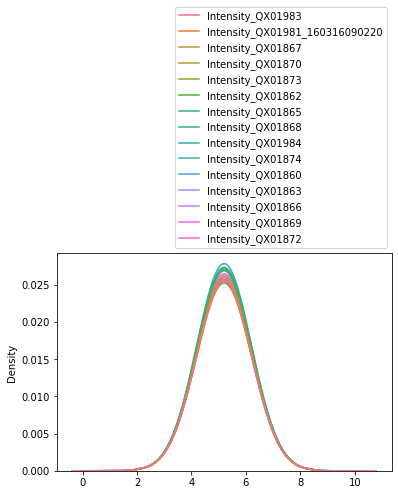

In [15]:
ax = sns.kdeplot(data=PXD014381[cols])
sns.move_legend(ax, "lower right", bbox_to_anchor=(1, 1))

In [20]:
PXD014381["Modifications"] = PXD014381["Sequence"].apply(modifications)
PXD014381["Delta_mass"] = PXD014381["Sequence"].apply(get_delta_mass)

In [21]:
No_zero = PXD014381[PXD014381["Delta_mass"] != 0]

In [22]:
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [26]:
g

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,Intensity_QX01868,Intensity_QX01984,Intensity_QX01874,Intensity_QX01860,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872
0,-94.04,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-89.03,0.0,0.0,669.977388,632.834715,621.846614,659.628293,661.026530,678.871587,660.599113,663.814373,635.090101,703.020248,683.854039,697.792001,722.468850,659.822389,678.541949
2,-73.04,0.0,0.0,10.874014,11.993166,9.492827,11.761398,9.365187,9.375392,3.708968,9.525058,11.857800,15.491974,23.896714,10.689270,10.688299,5.847078,8.975578
3,-58.01,0.0,0.0,16.756921,15.452487,17.086923,17.049385,17.536184,16.373933,20.720705,20.054132,15.638463,21.417628,17.700084,18.326001,17.656430,17.510405,13.444220
4,-48.00,0.0,0.0,25.309385,18.668003,25.403197,26.203161,17.989924,17.177803,22.398992,9.529475,18.503936,16.315347,10.079907,14.909238,18.204291,23.113798,28.393015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,473.22,0.0,0.0,13.974396,24.328940,27.437298,25.005404,13.166546,18.093629,20.806081,16.999216,18.805100,23.038315,28.213004,22.242427,18.340650,13.283519,27.289160
672,474.25,0.0,0.0,4.381641,3.528164,4.406369,3.401678,4.599225,4.010634,4.060650,4.376823,0.000000,3.947146,4.428627,0.000000,0.000000,3.450630,3.887248
673,489.21,0.0,0.0,4.551699,0.000000,4.421979,4.870310,4.044406,4.661367,5.145375,4.425406,4.762544,4.546206,4.796450,4.767583,4.215679,4.497040,4.142111
674,511.23,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [84]:
from statistics import median


g['medianCtrl']=g.apply(lambda x:median([x[c] for c in ['Intensity_QX01983', 'Intensity_QX01981_160316090220', 'Intensity_QX01867', 'Intensity_QX01870', 'Intensity_QX01873']]),axis=1)
g["medianRA"]=g.apply(lambda x:median([x[c] for c in ['Intensity_QX01860','Intensity_QX01863','Intensity_QX01866','Intensity_QX01869','Intensity_QX01872']]), axis=1)
g["medianDiamide"] = g.apply(lambda x:median([x[c] for c in ['Intensity_QX01862','Intensity_QX01865','Intensity_QX01868','Intensity_QX01984','Intensity_QX01874']]), axis=1)
# g['Quotient']=(g["medianRA"] - g["medianCtrl"]) / max([g["medianCtrl"], g["medianRA"]])
# g["Quotient"] = ((g["medianRA"] - g["medianCtrl"])/ g["medianCtrl"]).where( g["medianCtrl"] >= g["medianRA"], other=(g["medianRA"] - g["medianCtrl"])/ g["medianRA"])
# g["Quotient"] = ((g["medianRA"] - g["medianCtrl"])/ g["medianRA"]).where( g["medianCtrl"] < g["medianRA"])
g["Difference"] = (g["medianRA"] - g["medianCtrl"])
g["DiaDifference"] = (g["medianDiamide"] - g["medianCtrl"])
g["DiaRADifference"] = (g["medianDiamide"] - g["medianRA"])

### Plots

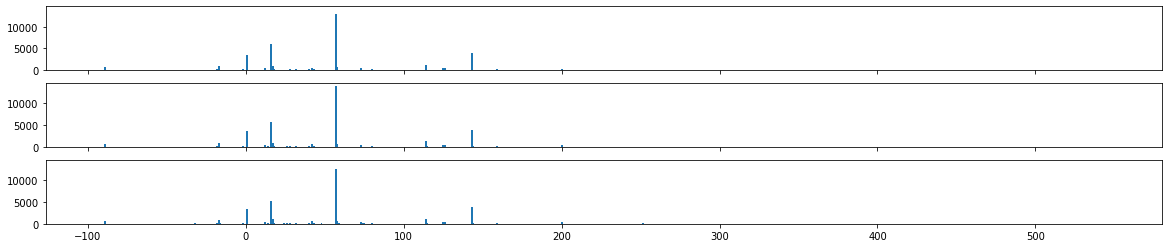

In [85]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols = 1, nrows=3, sharey = True, sharex=True)
# sns.barplot(ax = axes[0], data=gfiltered, x="Delta_mass", y="meanH2O2")
# sns.barplot(ax = axes[1], data=gfiltered, x="Delta_mass", y="meanCtrl")
ax1.bar(x=g.Delta_mass, height=g.medianRA, width=1.2)
ax3.bar(x=g.Delta_mass, height=g.medianCtrl, width=1.2)
ax2.bar(x=g.Delta_mass, height=g.medianDiamide, width=1.2)
ax1.hlines(y=0,xmin=-90, xmax=580, color="k")
ax2.hlines(y=0,xmin=-90, xmax=580, color="k")
ax3.hlines(y=0,xmin=-90, xmax=580, color="k")

fig.set_size_inches(20,4)
# plt.ylim(0,4000)
plt.show()

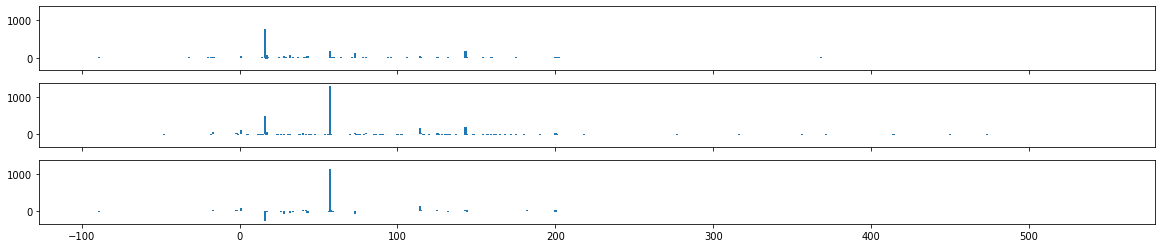

In [86]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols = 1, nrows=3, sharey = True, sharex=True)
# sns.barplot(ax = axes[0], data=gfiltered, x="Delta_mass", y="meanH2O2")
# sns.barplot(ax = axes[1], data=gfiltered, x="Delta_mass", y="meanCtrl")
ax1.bar(x=g.Delta_mass, height=g.Difference, width=1.4)
ax2.bar(x=g.Delta_mass, height=g.DiaDifference, width=1.4)
ax3.bar(x=g.Delta_mass, height=g.DiaRADifference, width=1.4)

fig.set_size_inches(20,4)
# plt.ylim(0,4000)
plt.show()

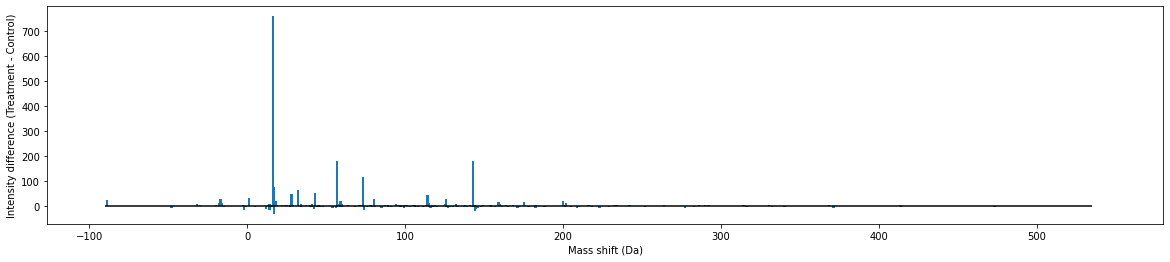

In [87]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.Difference, width=1.4)
fig.set_size_inches(20,4)
plt.hlines(y=0,xmin=-90, xmax=535, color="k")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Intensity difference (Treatment - Control)")
# plt.ylim(200)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])

plt.show()

In [32]:
sorted = g.sort_values(by="Difference", axis=0, ascending=False)

In [34]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,...,Intensity_QX01984,Intensity_QX01874,Intensity_QX01860,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,medianCtrl,medianRA,Difference
51,15.99,0.0,0.0,5076.553919,5338.005444,5280.554182,5014.609819,5585.788895,5780.105151,5672.952714,...,5457.207241,6126.850844,7088.481030,6039.786537,7352.561980,5255.577474,5681.817661,5280.554182,6039.786537,759.232355
362,143.06,0.0,0.0,3695.772552,3761.864952,3850.136959,3769.240325,3635.853632,3984.106373,3966.217098,...,3885.805391,3954.923851,3768.794006,4049.924070,3942.680075,3993.402616,3881.489216,3761.864952,3942.680075,180.815123
137,57.02,0.0,0.0,12330.284023,12661.846831,12943.012047,12919.112353,12087.766307,12957.476077,13963.615646,...,13955.656266,14150.926184,11792.674086,13403.490883,12161.616314,13236.289900,12841.110548,12661.846831,12841.110548,179.263717
175,73.01,0.0,0.0,397.559002,515.836520,537.694835,480.462133,466.113754,528.308791,572.310293,...,522.625712,611.893881,615.321412,596.317291,705.136707,511.911695,549.186616,480.462133,596.317291,115.855159
52,16.97,0.0,0.0,359.670707,374.440705,365.738966,374.298334,438.587927,456.380508,427.675938,...,358.737113,504.482018,485.521426,450.839448,479.556002,369.548799,438.565890,374.298334,450.839448,76.541114
84,31.98,0.0,0.0,147.899212,182.560721,170.708420,155.292167,169.711309,223.098597,192.224091,...,165.857684,216.103403,341.927738,234.592422,338.727080,163.312524,190.085211,169.711309,234.592422,64.881114
108,43.01,0.0,0.0,232.616798,234.834448,267.612648,261.213190,241.835143,256.586542,249.434180,...,272.917308,284.518865,240.754163,336.640608,358.291187,277.606597,293.202169,241.835143,293.202169,51.367025
72,27.99,0.0,0.0,166.265291,192.525058,198.037560,193.718898,185.530218,164.735700,159.312152,...,196.548560,204.613748,242.983378,241.300321,311.540765,199.405259,243.613940,192.525058,242.983378,50.458320
278,114.04,0.0,0.0,1041.983794,1137.324483,1226.985507,1152.268319,1034.256813,1181.604017,1311.174477,...,1340.364346,1389.824599,976.701168,1181.208875,1095.347486,1192.343708,1202.381439,1137.324483,1181.208875,43.884392
34,0.98,0.0,0.0,3335.433849,3471.053355,3450.680197,3479.110033,3406.100366,3591.129297,3490.359587,...,3444.260010,3829.295385,3476.634507,3595.570663,3404.849001,3484.750221,3580.946308,3450.680197,3484.750221,34.070025


RA - Control:

15.99: oxidation!

143.06: Nethylmaleimide + water (something sample prep read article)

57: Carbamidomethyl

73: Carbamidomethyl + Oxidation

17: Oxidation + Deamidation

32: Dioxidation!

43: Carbamyl

28: Formyl

114: Ubiquitination

0.98: Deamidation

In [35]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,...,Intensity_QX01984,Intensity_QX01874,Intensity_QX01860,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,medianCtrl,medianRA,Difference
372,145.03,0.0,0.0,20.694991,19.507252,14.260155,10.018130,16.007057,14.565955,8.365517,...,19.509827,18.756209,5.901894,13.777333,4.137313,10.427544,3.499754,16.007057,5.901894,-10.105163
40,12.00,0.0,0.0,462.796523,422.076899,465.729927,472.290245,436.855458,439.277167,481.104168,...,453.508158,483.271939,440.347034,452.351294,407.449898,481.101399,482.213628,462.796523,452.351294,-10.445229
107,42.05,0.0,0.0,67.539492,63.581825,62.879582,61.310665,60.215458,58.855789,56.379965,...,62.330983,41.497443,51.015636,49.888665,54.049878,49.838755,58.421351,62.879582,51.015636,-11.863946
106,42.02,0.0,0.0,89.975209,106.405226,106.161000,107.196831,114.517368,135.740355,120.470612,...,134.080197,113.225187,94.231683,76.395372,94.411266,102.931817,96.632024,106.405226,94.411266,-11.993960
105,42.01,0.0,0.0,580.202026,574.485802,688.568214,665.128791,649.788240,678.917755,669.712353,...,611.535597,690.437542,605.250683,676.839575,614.899181,636.910198,683.353218,649.788240,636.910198,-12.878042
179,74.05,0.0,0.0,101.162351,114.907489,90.185893,95.398448,105.151412,78.911092,87.116189,...,106.793692,81.289962,86.427989,96.597492,101.101499,87.430503,80.920027,101.162351,87.430503,-13.731848
46,14.02,0.0,0.0,165.471826,178.381006,167.689171,151.911195,140.664189,145.121208,155.603863,...,143.514635,150.124591,171.307768,149.468178,142.402486,141.073105,154.577043,165.471826,149.468178,-16.003648
30,-2.02,0.0,0.0,257.905571,232.669595,246.935848,175.901640,260.773198,215.392482,273.704825,...,272.120190,285.961498,228.360620,250.041867,210.688511,230.339612,237.790131,246.935848,230.339612,-16.596236
367,144.07,0.0,0.0,152.108753,191.242537,137.419281,165.088628,170.685630,171.926159,191.681968,...,198.662699,187.934543,145.607526,193.746625,142.012829,143.605467,166.787731,165.088628,145.607526,-19.481103
53,17.03,0.0,0.0,1150.621389,1168.603368,918.129994,950.828089,1038.528339,1001.156048,1072.221230,...,1155.131140,1009.822316,963.216846,1040.987433,1007.468887,1055.956527,941.781084,1038.528339,1007.468887,-31.059452


17: Ammonium

144: phosphorylation to amine thiol + carbamidomethyl

-2: Didehydro or Intact disulfide bridge or oxidation + dehydration

14: methylation

74: Carbamidomethyl + Ammonium

42.01: Acetyl

42.02: AMidino or Guanidinaiton

42.05: Trimethyl

12: formaldehyde adduct

145.03: Oxidation + monoglutamyl





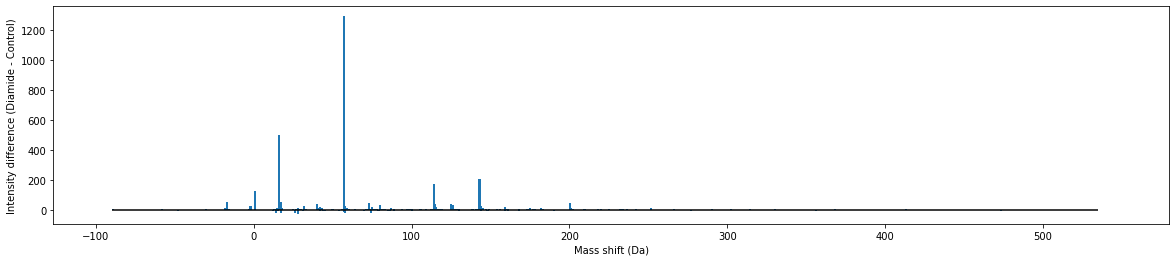

In [88]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.DiaDifference, width=1.4)
fig.set_size_inches(20,4)
plt.hlines(y=0,xmin=-90, xmax=535, color="k")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Intensity difference (Diamide - Control)")
# plt.ylim(200)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])

plt.show()

In [89]:
sorted = g.sort_values(by="DiaDifference", axis=0, ascending=False)

In [90]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,...,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,medianCtrl,medianRA,Difference,medianDiamide,DiaDifference,DiaRADifference
137,57.02,0.0,0.0,12330.284023,12661.846831,12943.012047,12919.112353,12087.766307,12957.476077,13963.615646,...,13403.490883,12161.616314,13236.289900,12841.110548,12661.846831,12841.110548,179.263717,13955.656266,1293.809435,1114.545718
51,15.99,0.0,0.0,5076.553919,5338.005444,5280.554182,5014.609819,5585.788895,5780.105151,5672.952714,...,6039.786537,7352.561980,5255.577474,5681.817661,5280.554182,6039.786537,759.232355,5780.105151,499.550968,-259.681387
362,143.06,0.0,0.0,3695.772552,3761.864952,3850.136959,3769.240325,3635.853632,3984.106373,3966.217098,...,4049.924070,3942.680075,3993.402616,3881.489216,3761.864952,3942.680075,180.815123,3966.217098,204.352146,23.537023
278,114.04,0.0,0.0,1041.983794,1137.324483,1226.985507,1152.268319,1034.256813,1181.604017,1311.174477,...,1181.208875,1095.347486,1192.343708,1202.381439,1137.324483,1181.208875,43.884392,1311.174477,173.849994,129.965601
34,0.98,0.0,0.0,3335.433849,3471.053355,3450.680197,3479.110033,3406.100366,3591.129297,3490.359587,...,3595.570663,3404.849001,3484.750221,3580.946308,3450.680197,3484.750221,34.070025,3576.921318,126.241121,92.171097
20,-17.03,0.0,0.0,855.461683,852.039058,871.109863,883.513941,888.536124,940.446993,893.495504,...,925.320992,899.647292,897.278493,872.143217,871.109863,899.647292,28.537429,926.287818,55.177954,26.640525
52,16.97,0.0,0.0,359.670707,374.440705,365.738966,374.298334,438.587927,456.380508,427.675938,...,450.839448,479.556002,369.548799,438.565890,374.298334,450.839448,76.541114,427.675938,53.377604,-23.163510
175,73.01,0.0,0.0,397.559002,515.836520,537.694835,480.462133,466.113754,528.308791,572.310293,...,596.317291,705.136707,511.911695,549.186616,480.462133,596.317291,115.855159,528.308791,47.846658,-68.008500
504,200.08,0.0,0.0,320.728461,317.771966,315.185355,323.479606,320.371053,365.105748,356.877976,...,351.312932,341.030013,338.641040,340.968982,320.371053,340.968982,20.597929,365.105748,44.734695,24.136765
100,39.99,0.0,0.0,219.268517,233.795424,239.859470,253.018017,225.779291,266.259376,280.277399,...,265.874684,233.994455,248.569804,236.821335,233.795424,236.821335,3.025911,274.433433,40.638009,37.612098


Diamide - Control:

57: Carbamidomethyl

16: Oxidation

143: Nethylmaleimide+water	

114.04: Ubiquitination

0.98: Deamidation

-17: Pyro-glu from Q or ammonia loss

17: Oxidation + deamidation

73: Carbamidomethyl + Oxidation

200: Carbamidomethyl + NEM

40: Pyro-carbamidomethyl or carbamidomethyl + pyro-glu or carbamidomethyl + ammonia-loss






In [91]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,...,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,medianCtrl,medianRA,Difference,medianDiamide,DiaDifference,DiaRADifference
4,-48.00,0.0,0.0,25.309385,18.668003,25.403197,26.203161,17.989924,17.177803,22.398992,...,14.909238,18.204291,23.113798,28.393015,25.309385,18.204291,-7.105094,17.177803,-8.131582,-1.026487
322,130.03,0.0,0.0,50.739130,54.225722,53.459843,54.863943,33.497380,44.232675,43.621336,...,43.781762,51.503029,54.151635,48.619076,53.459843,51.419853,-2.039989,44.232675,-9.227168,-7.187179
40,12.00,0.0,0.0,462.796523,422.076899,465.729927,472.290245,436.855458,439.277167,481.104168,...,452.351294,407.449898,481.101399,482.213628,462.796523,452.351294,-10.445229,453.508158,-9.288365,1.156864
136,56.99,0.0,0.0,52.526994,54.115662,58.046632,50.375764,56.440556,35.977484,46.753475,...,57.885089,44.393170,61.481275,50.235156,54.115662,50.235156,-3.880506,40.833292,-13.282370,-9.401864
66,26.02,0.0,0.0,136.244290,148.067592,153.786925,152.119581,128.025870,129.578148,142.554380,...,153.994621,149.480247,145.176173,128.981165,148.067592,149.480247,1.412654,128.808785,-19.258807,-20.671462
179,74.05,0.0,0.0,101.162351,114.907489,90.185893,95.398448,105.151412,78.911092,87.116189,...,96.597492,101.101499,87.430503,80.920027,101.162351,87.430503,-13.731848,81.289962,-19.872389,-6.140541
46,14.02,0.0,0.0,165.471826,178.381006,167.689171,151.911195,140.664189,145.121208,155.603863,...,149.468178,142.402486,141.073105,154.577043,165.471826,149.468178,-16.003648,145.121208,-20.350619,-4.346970
139,58.01,0.0,0.0,220.277526,216.506223,238.401215,225.504740,239.928067,184.711945,220.616852,...,234.669738,233.962091,206.677781,250.019941,225.504740,233.962091,8.457351,201.648293,-23.856447,-32.313798
53,17.03,0.0,0.0,1150.621389,1168.603368,918.129994,950.828089,1038.528339,1001.156048,1072.221230,...,1040.987433,1007.468887,1055.956527,941.781084,1038.528339,1007.468887,-31.059452,1014.277989,-24.250349,6.809103
72,27.99,0.0,0.0,166.265291,192.525058,198.037560,193.718898,185.530218,164.735700,159.312152,...,241.300321,311.540765,199.405259,243.613940,192.525058,242.983378,50.458320,164.735700,-27.789359,-78.247678


28: Formylation

17.03: Ammonium

58: Carboxymethyl or oxidation + guanidinyl

14: Methylation

74: Carbamidomethyl + Ammonium

26.02: Acetaldehyde adduct

56.99: Oxidation + Azidophenylalanine

12: formaldehyde adduct

130.03: many possibles, look 

-48: Met->Hsl









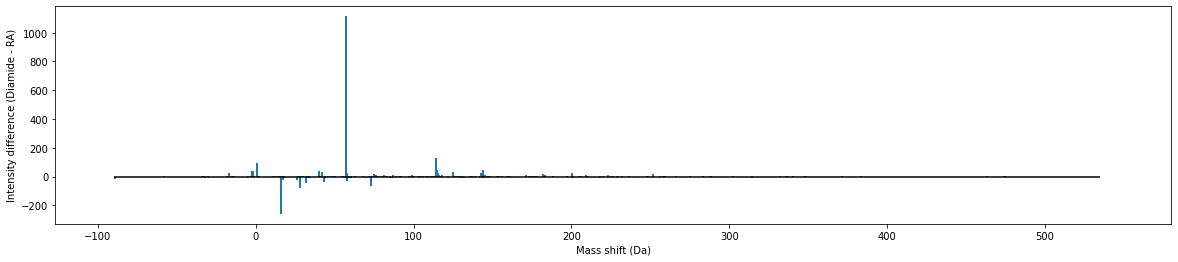

In [92]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.DiaRADifference, width=1.4)
fig.set_size_inches(20,4)
plt.hlines(y=0,xmin=-90, xmax=535, color="k")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Intensity difference (Diamide - RA)")
# plt.ylim(200)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])

plt.show()

In [93]:
sorted = g.sort_values(by="DiaRADifference", axis=0, ascending=False)

In [94]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,...,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,medianCtrl,medianRA,Difference,medianDiamide,DiaDifference,DiaRADifference
137,57.02,0.0,0.0,12330.284023,12661.846831,12943.012047,12919.112353,12087.766307,12957.476077,13963.615646,...,13403.490883,12161.616314,13236.289900,12841.110548,12661.846831,12841.110548,179.263717,13955.656266,1293.809435,1114.545718
278,114.04,0.0,0.0,1041.983794,1137.324483,1226.985507,1152.268319,1034.256813,1181.604017,1311.174477,...,1181.208875,1095.347486,1192.343708,1202.381439,1137.324483,1181.208875,43.884392,1311.174477,173.849994,129.965601
34,0.98,0.0,0.0,3335.433849,3471.053355,3450.680197,3479.110033,3406.100366,3591.129297,3490.359587,...,3595.570663,3404.849001,3484.750221,3580.946308,3450.680197,3484.750221,34.070025,3576.921318,126.241121,92.171097
281,115.03,0.0,0.0,111.608671,115.204517,92.970167,117.878982,104.808764,98.679811,154.119259,...,106.456958,85.023604,119.179976,128.542882,111.608671,106.456958,-5.151712,150.697680,39.089009,44.240722
367,144.07,0.0,0.0,152.108753,191.242537,137.419281,165.088628,170.685630,171.926159,191.681968,...,193.746625,142.012829,143.605467,166.787731,165.088628,145.607526,-19.481103,187.934543,22.845915,42.327018
30,-2.02,0.0,0.0,257.905571,232.669595,246.935848,175.901640,260.773198,215.392482,273.704825,...,250.041867,210.688511,230.339612,237.790131,246.935848,230.339612,-16.596236,272.120190,25.184342,41.780578
100,39.99,0.0,0.0,219.268517,233.795424,239.859470,253.018017,225.779291,266.259376,280.277399,...,265.874684,233.994455,248.569804,236.821335,233.795424,236.821335,3.025911,274.433433,40.638009,37.612098
105,42.01,0.0,0.0,580.202026,574.485802,688.568214,665.128791,649.788240,678.917755,669.712353,...,676.839575,614.899181,636.910198,683.353218,649.788240,636.910198,-12.878042,669.712353,19.924113,32.802155
309,125.05,0.0,0.0,506.555067,529.834370,536.203566,522.670870,510.542083,569.967060,550.334414,...,552.643591,529.574488,537.036462,526.688131,522.670870,529.574488,6.903618,561.785493,39.114623,32.211005
106,42.02,0.0,0.0,89.975209,106.405226,106.161000,107.196831,114.517368,135.740355,120.470612,...,76.395372,94.411266,102.931817,96.632024,106.405226,94.411266,-11.993960,122.240776,15.835549,27.829509


Diamide - RA:

57.02: Carbamidomethyl

114: many possibilities, mostly with carbamidomethylation

0.98: Deamidation

115.03: Carbamidomethyl + Carboxymethyl

144: Carbamidomethyl + phosphorylation to amine thiol

-2: Didehydro or oxidation + glu => pyro-glu

-40: 	Pyro-carbamidomethyl or other things

42.01: Acetylation

125: NEM

42.02: Guanidiniation or amidino









In [95]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,...,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,medianCtrl,medianRA,Difference,medianDiamide,DiaDifference,DiaRADifference
503,200.07,0.0,0.0,31.873260,37.075469,34.769375,36.626099,29.810970,29.958809,26.945690,...,44.573727,28.152810,45.900126,43.082088,34.769375,43.082088,8.312713,29.958809,-4.810566,-13.123279
1,-89.03,0.0,0.0,669.977388,632.834715,621.846614,659.628293,661.026530,678.871587,660.599113,...,697.792001,722.468850,659.822389,678.541949,659.628293,683.854039,24.225745,663.814373,4.186080,-20.039666
66,26.02,0.0,0.0,136.244290,148.067592,153.786925,152.119581,128.025870,129.578148,142.554380,...,153.994621,149.480247,145.176173,128.981165,148.067592,149.480247,1.412654,128.808785,-19.258807,-20.671462
52,16.97,0.0,0.0,359.670707,374.440705,365.738966,374.298334,438.587927,456.380508,427.675938,...,450.839448,479.556002,369.548799,438.565890,374.298334,450.839448,76.541114,427.675938,53.377604,-23.163510
139,58.01,0.0,0.0,220.277526,216.506223,238.401215,225.504740,239.928067,184.711945,220.616852,...,234.669738,233.962091,206.677781,250.019941,225.504740,233.962091,8.457351,201.648293,-23.856447,-32.313798
108,43.01,0.0,0.0,232.616798,234.834448,267.612648,261.213190,241.835143,256.586542,249.434180,...,336.640608,358.291187,277.606597,293.202169,241.835143,293.202169,51.367025,256.586542,14.751398,-36.615627
84,31.98,0.0,0.0,147.899212,182.560721,170.708420,155.292167,169.711309,223.098597,192.224091,...,234.592422,338.727080,163.312524,190.085211,169.711309,234.592422,64.881114,192.224091,22.512782,-42.368332
175,73.01,0.0,0.0,397.559002,515.836520,537.694835,480.462133,466.113754,528.308791,572.310293,...,596.317291,705.136707,511.911695,549.186616,480.462133,596.317291,115.855159,528.308791,47.846658,-68.008500
72,27.99,0.0,0.0,166.265291,192.525058,198.037560,193.718898,185.530218,164.735700,159.312152,...,241.300321,311.540765,199.405259,243.613940,192.525058,242.983378,50.458320,164.735700,-27.789359,-78.247678
51,15.99,0.0,0.0,5076.553919,5338.005444,5280.554182,5014.609819,5585.788895,5780.105151,5672.952714,...,6039.786537,7352.561980,5255.577474,5681.817661,5280.554182,6039.786537,759.232355,5780.105151,499.550968,-259.681387


15.99: Oxidation

27.99: Formylation

73: Oxidation + Carbamidomethyl

31.98: Dioxidation

43.01: Carbamyl

58.01: Carboxymethyl

16.97: Oxidation + Deamidation

26.02: Acetaldehyde adduct

-89.03: Met-loss + Acetyl

200: Oxidaiton + MTSL



# PXD024844

In [2]:
cols = ['Intensity_20200828_1_5ug_testis_ingwar',
       'Intensity_20200828_1_5ug_testis_obelisk',
       'Intensity_20200828_1_5ug_testis_timon',
       'Intensity_20200828_1_5ug_testis_wonny',
       'Intensity_20200828_1_5ug_testis_bellamo',
       'Intensity_20200828_1_5ug_testis_bendix',
       'Intensity_20200828_1_5ug_testis_ilineus',
       'Intensity_20200828_1_5ug_testis_kalonso',
       'Intensity_20200828_1_5ug_testis_primat',
       'Intensity_20200828_1_5ug_testis_vitali']

In [3]:
PXD024844 = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD024844/quant/QuantifiedPeptides.tsv", sep="\t")
PXD024844.drop(list(PXD024844.filter(regex = 'Detection Type')), axis = 1, inplace = True)
PXD024844 = PXD024844[~PXD024844["Protein Groups"].str.contains("sp|", na=False, regex=False)]

In [4]:
OA.quantile_transform(PXD024844, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20200828_1_5ug_testis_ingwar,Intensity_20200828_1_5ug_testis_obelisk,Intensity_20200828_1_5ug_testis_timon,Intensity_20200828_1_5ug_testis_wonny,Intensity_20200828_1_5ug_testis_bellamo,Intensity_20200828_1_5ug_testis_bendix,Intensity_20200828_1_5ug_testis_ilineus,Intensity_20200828_1_5ug_testis_kalonso,Intensity_20200828_1_5ug_testis_primat,Intensity_20200828_1_5ug_testis_vitali,Unnamed: 25
0,AAAAAAAAAAAAAASAGGK15|[9999514]HexNAc[S],AAAAAAAAAAAAAASAGGK,A0A5F4VSA7_CALJA,NaN,NaN,5.628438,NaN,NaN,NaN,5.341195,NaN,NaN,4.945920,NaN,5.336755,NaN
1,AAAAAAAAAAAAAASAGGKnan,AAAAAAAAAAAAAASAGGK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAAAAAAAAVSRnan,AAAAAAAAAAAVSR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAAAAAAACAAGGR11|Gly->Cys[G],AAAAAAAAAACAAGGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAAAAAAAAGAAGGR0|[1]Acetyl[N-TERM],AAAAAAAAAAGAAGGR,NaN,NaN,NaN,6.463875,NaN,6.241301,6.394788,6.063308,6.482428,6.364981,6.516074,6.410457,6.039317,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146977,YYYVCQYCPAGNNVQTK5|[4]carbamidomethyl[C]|8|[13...,YYYVCQYCPAGNNVQTK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146978,YYYVCQYCPAGNNVQTK5|[4]carbamidomethyl[C]|8|[4]...,YYYVCQYCPAGNNVQTK,NaN,NaN,NaN,5.454265,6.092034,5.889248,6.074279,5.926417,5.864313,5.946097,6.037934,6.016080,6.001096,NaN
146979,YYYVCQYCPAGNNVQTK5|[4]carbamidomethyl[C]|8|[6]...,YYYVCQYCPAGNNVQTK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146980,YYYVCQYCPAGNNVQTK8|[4]carbamidomethyl[C]|5|[6]...,YYYVCQYCPAGNNVQTK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


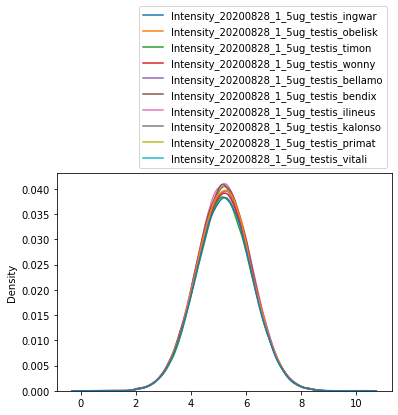

In [5]:
ax = sns.kdeplot(data=PXD024844[cols])
sns.move_legend(ax, "lower right", bbox_to_anchor=(1, 1))

In [10]:
PXD024844["Modifications"] = PXD024844["Sequence"].apply(modifications)
PXD024844["Delta_mass"] = PXD024844["Sequence"].apply(get_delta_mass)

In [11]:
No_zero = PXD024844[PXD024844["Delta_mass"] != 0]

In [12]:
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [13]:
YoungID = ['Intensity_20200828_1_5ug_testis_bellamo','Intensity_20200828_1_5ug_testis_bendix','Intensity_20200828_1_5ug_testis_ilineus','Intensity_20200828_1_5ug_testis_kalonso','Intensity_20200828_1_5ug_testis_primat','Intensity_20200828_1_5ug_testis_vitali']
OldID = ['Intensity_20200828_1_5ug_testis_ingwar','Intensity_20200828_1_5ug_testis_obelisk','Intensity_20200828_1_5ug_testis_timon','Intensity_20200828_1_5ug_testis_wonny',]

In [14]:

from statistics import median


g['medianYoung']=g.apply(lambda x:median([x[c] for c in YoungID]),axis=1)
g["medianOld"]=g.apply(lambda x:median([x[c] for c in OldID]), axis=1)
# g['Quotient']=(g["medianOld"] - g["medianYoung"]) / max([g["medianYoung"], g["medianOld"]])
# g["Quotient"] = ((g["medianOld"] - g["medianYoung"])/ g["medianYoung"]).where( g["medianYoung"] >= g["medianOld"], other=(g["medianOld"] - g["medianYoung"])/ g["medianOld"])
# g["Quotient"] = ((g["medianOld"] - g["medianYoung"])/ g["medianOld"]).where( g["medianYoung"] < g["medianOld"])
g["Difference"] = (g["medianOld"] - g["medianYoung"])

### Plots

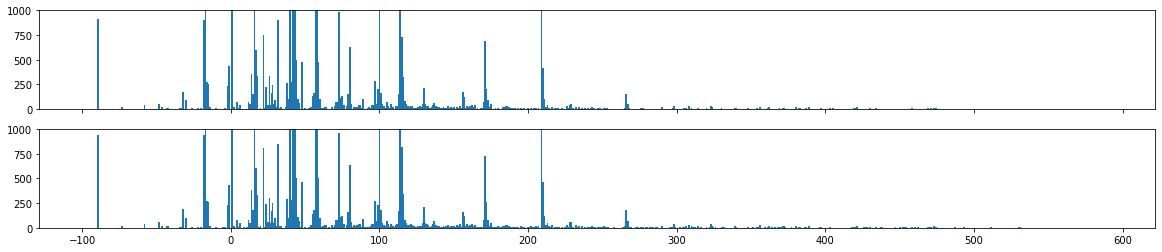

In [15]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)
# sns.barplot(ax = axes[0], data=gfiltered, x="Delta_mass", y="medianOld")
# sns.barplot(ax = axes[1], data=gfiltered, x="Delta_mass", y="meanCtrl")
ax1.bar(x=g.Delta_mass, height=g.medianOld, width=1.2)
ax2.bar(x=g.Delta_mass, height=g.medianYoung, width=1.2)

fig.set_size_inches(20,4)
plt.ylim(0,1000)
plt.show()

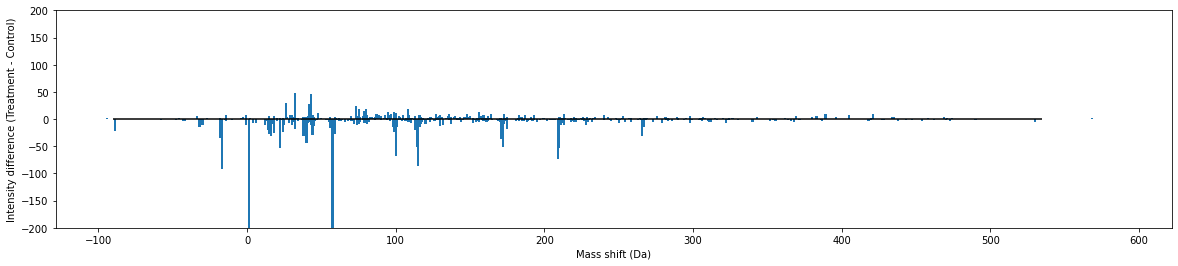

In [16]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.Difference, width=1.4)
fig.set_size_inches(20,4)
plt.hlines(y=0,xmin=-90, xmax=535, color="k")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Intensity difference (Treatment - Control)")
plt.ylim(-200,200)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

In [17]:
sorted = g.sort_values(by="Difference", axis=0, ascending=False)

In [18]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_20200828_1_5ug_testis_ingwar,Intensity_20200828_1_5ug_testis_obelisk,Intensity_20200828_1_5ug_testis_timon,Intensity_20200828_1_5ug_testis_wonny,Intensity_20200828_1_5ug_testis_bellamo,Intensity_20200828_1_5ug_testis_bendix,Intensity_20200828_1_5ug_testis_ilineus,Intensity_20200828_1_5ug_testis_kalonso,Intensity_20200828_1_5ug_testis_primat,Intensity_20200828_1_5ug_testis_vitali,Unnamed: 25,medianYoung,medianOld,Difference
110,31.99,0.0,0.0,879.340985,934.249324,842.401525,920.789723,818.352605,883.127625,819.323818,788.728815,942.026475,896.964290,0.0,851.225721,900.065354,48.839633
139,43.01,0.0,0.0,15316.810294,15694.017200,14845.632897,15729.028079,14882.516567,16698.349590,15707.987931,15210.868904,16122.757753,15147.987047,0.0,15459.428417,15505.413747,45.985330
90,26.02,0.0,0.0,335.306054,330.434540,323.830602,367.676892,283.705243,282.898042,333.290745,260.415741,344.486833,323.518016,0.0,303.611630,332.870297,29.258667
136,42.01,0.0,0.0,2172.944218,2230.156745,2235.191321,2204.268057,2144.199572,2259.966518,2176.672576,2201.643579,2282.208064,2080.212682,0.0,2189.158078,2217.212401,28.054323
243,73.01,0.0,0.0,1020.706360,1021.775787,949.472929,932.401817,1016.433765,903.642090,995.418378,927.358220,1052.666816,906.504192,0.0,961.388299,985.089645,23.701346
272,79.96,0.0,0.0,42.353643,40.966258,31.488408,20.137389,12.466380,17.608431,32.016586,17.821963,36.451894,17.050385,0.0,17.715197,36.227333,18.512136
378,108.00,0.0,0.0,56.833622,47.443457,66.275169,52.663460,20.933028,46.802042,38.068749,10.641297,52.665825,35.721381,0.0,36.895065,54.748541,17.853476
251,75.03,0.0,0.0,105.330419,134.049093,136.476223,130.837127,116.577628,112.920310,111.319603,133.517740,114.599393,114.581144,0.0,114.590268,132.443110,17.852842
267,78.99,0.0,0.0,113.865477,108.827596,108.353809,113.364563,98.356445,95.751724,99.376690,86.463802,101.508557,93.906716,0.0,97.054084,111.096080,14.041995
322,94.97,0.0,0.0,38.988824,51.299987,42.577541,59.125791,39.791702,40.903551,24.661592,32.775753,33.440256,33.419564,0.0,33.429910,46.938764,13.508854


32: Dioxidation (sure)

5: Carbamyl (hallmark of aging!)

26: Acetaldehyde +26 

42: Acetylation

73: Oxidation + Carbamidomethyl

80: phosphorylation

108: 	O-Dimethylphosphate or O-ethylphosphate

75: Proline oxidation to 5-hydroxy-2-aminovaleric acid	+ Carbamidomethyl

79: Carbamidomethyl + Replacement of 2 protons by magnesium	

95: Carbamidomethyl + Replacement of 2 protons by calcium	




In [42]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_20200828_1_5ug_testis_ingwar,Intensity_20200828_1_5ug_testis_obelisk,Intensity_20200828_1_5ug_testis_timon,Intensity_20200828_1_5ug_testis_wonny,Intensity_20200828_1_5ug_testis_bellamo,Intensity_20200828_1_5ug_testis_bendix,Intensity_20200828_1_5ug_testis_ilineus,Intensity_20200828_1_5ug_testis_kalonso,Intensity_20200828_1_5ug_testis_primat,Intensity_20200828_1_5ug_testis_vitali,Unnamed: 25,medianYoung,medianOld,Difference
83,21.98,0.0,0.0,745.074370,741.658940,756.708960,812.634882,823.569595,795.030519,787.985297,813.511202,831.945960,760.464008,0.0,804.270860,750.891665,-53.379195
190,58.01,0.0,0.0,968.977645,969.746882,950.384653,964.901631,1069.164579,1078.924402,1073.104960,999.599473,848.762501,901.745343,0.0,1034.382026,966.939638,-67.442387
345,100.03,0.0,0.0,1770.344929,2016.332092,1914.447872,1899.006786,1846.424740,2086.592267,2017.417246,1931.666314,1982.746849,1966.407575,0.0,1974.577212,1906.727329,-67.849883
786,209.02,0.0,0.0,1342.573299,1161.070466,899.763737,1237.357075,1381.861976,1103.232602,1300.982075,1364.290440,1105.827848,1241.425272,0.0,1271.203674,1199.213771,-71.989903
407,115.02,0.0,0.0,692.146689,754.736286,786.583840,716.482354,807.123082,844.642499,835.781993,843.010533,719.279420,745.673713,0.0,821.452538,735.609320,-85.843218
24,-17.03,0.0,0.0,2474.823078,2667.302082,2477.232132,2489.492050,2550.325693,2534.754929,2575.057714,2671.173132,2577.375305,2668.455940,0.0,2576.216509,2483.362091,-92.854418
191,58.04,0.0,0.0,950.427257,932.761141,919.519346,1022.893196,1160.560392,1115.110844,1098.842542,1093.965983,998.212769,948.871457,0.0,1096.404263,941.594199,-154.810064
189,58.00,0.0,0.0,5274.109556,5313.775217,5648.168323,5427.603065,5819.883450,5897.167206,5902.091082,5938.222819,5257.929980,5375.534031,0.0,5858.525328,5370.689141,-487.836187
46,0.98,0.0,0.0,19279.809113,17612.346822,17300.113313,17314.239060,18891.885181,18503.848296,19449.290648,18379.946417,16612.349174,17202.969098,0.0,18441.897356,17463.292941,-978.604415
188,57.02,0.0,0.0,36962.727334,42722.623181,41534.101023,42031.184404,42091.812951,43629.298839,44303.976473,43577.275876,42992.077008,42495.203004,0.0,43284.676442,41782.642713,-1502.033729


In [34]:
PXD024844[PXD024844["Delta_mass"] == 57.02]

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20200828_1_5ug_testis_ingwar,Intensity_20200828_1_5ug_testis_obelisk,Intensity_20200828_1_5ug_testis_timon,Intensity_20200828_1_5ug_testis_wonny,Intensity_20200828_1_5ug_testis_bellamo,Intensity_20200828_1_5ug_testis_bendix,Intensity_20200828_1_5ug_testis_ilineus,Intensity_20200828_1_5ug_testis_kalonso,Intensity_20200828_1_5ug_testis_primat,Intensity_20200828_1_5ug_testis_vitali,Unnamed: 25,Modifications,Delta_mass
50,AAAAALGSSSGSASPAVAELCQNTPETFLEASK21|[4]carbami...,AAAAALGSSSGSASPAVAELCQNTPETFLEASK,NaN,NaN,NaN,3.878728,NaN,NaN,4.534078,4.371067,NaN,4.130693,NaN,4.723858,NaN,NaN,"[4, 999911]",57.02
51,AAAAALGSSSGSASPAVAELCQNTPETFLEASK21|[4]carbami...,AAAAALGSSSGSASPAVAELCQNTPETFLEASK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 999915]",57.02
54,AAAAALGSSSGSASPAVAELCQNTPETFLEASK21|[4]carbami...,AAAAALGSSSGSASPAVAELCQNTPETFLEASK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[4, 999915]",57.02
71,AAAADHRQELIECVANSDEQLGEMFLEEK13|[4]carbamidome...,AAAADHRQELIECVANSDEQLGEMFLEEK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[4],57.02
92,AAAANLCPGDVILAIDGFGTESMTHADAQDR7|[4]carbamidom...,AAAANLCPGDVILAIDGFGTESMTHADAQDR,NaN,NaN,NaN,5.476716,4.975463,5.481544,5.058268,4.918584,4.943298,4.699638,4.765908,4.884871,4.614977,NaN,[4],57.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146918,YYNDCYAVLR5|[4]carbamidomethyl[C],YYNDCYAVLR,F6Z9S9_CALJA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[4],57.02
146926,YYQHLYSIHLAEQSEDCTMQLADHIK17|[4]carbamidomethy...,YYQHLYSIHLAEQSEDCTMQLADHIK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.584253,5.150617,NaN,NaN,NaN,NaN,[4],57.02
146932,YYSDLFSYCDIESTK9|[4]carbamidomethyl[C],YYSDLFSYCDIESTK,A0A8J8YP46_CALJA,NaN,NaN,5.702403,5.724381,5.733014,5.849724,5.905751,NaN,5.814576,4.660444,5.964753,NaN,NaN,[4],57.02
146933,YYSDLFSYCDIESTKK9|[4]carbamidomethyl[C],YYSDLFSYCDIESTKK,A0A8J8YP46_CALJA,NaN,NaN,4.268853,NaN,4.794035,4.270448,4.858972,NaN,4.828790,4.654265,NaN,NaN,NaN,[4],57.02


22: Sodium adduct

58: Carboxymethyl

100.03: Carbamidomethyl + Carbamyl

209: CarbamidomethylDTT

115.02: Two carbamidomethyl + deamidation

-17.03: Ammonia-loss 

58: Reduced acrolein addition +58

58.00: Carbamidomethyl + deamidation

0.98: Deamidation

57.02: Carbamidomethylation